# Recruiting Insight Engine — Model Training & Exploratory Data Analysis (EDA)

**PwC Challenge Submission**  
**Candidate:** Julio Rodriguez  

---

## Purpose

This notebook documents the full workflow used in the *Recruiting Insight Engine*:

- Load and inspect the processed dataset provided for the challenge.
- Perform a compact but meaningful Exploratory Data Analysis (EDA).
- Define the feature schema and preprocessing steps.
- Train and evaluate the main model used by the API.
- Export artifacts compatible with the FastAPI inference layer.
- Provide a lightweight bias/fairness diagnostics preview at the dataset level.

It is designed for **evaluation and reproducibility**, not as a production orchestrator.

---

## Scope and Alignment

- The logic here is aligned with the production script:  
  `app/ml/train_pipeline.py`
- The trained artifacts are exported to:  
  `app/ml/artifacts/preprocessor.pkl`  
  `app/ml/artifacts/model.pkl`
- The **FastAPI layer** under `app/ml/inference.py` expects those exact paths and schema.
- The **InsightEngine** (`app/insights/engine.py`) builds on top of this model to provide:
  - Market positioning
  - Cohort comparisons
  - Bias/fairness audit
  - Interpretability & narrative

This notebook focuses on **EDA + model training** and includes a **small bias diagnostics preview** based solely on the dataset statistics.


In [21]:
# MODULE 2 — Imports + Path Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

%matplotlib inline
sns.set_theme(style="whitegrid")

# Paths relative to project root
ROOT = Path(".").resolve()
DATA_PATH = ROOT / "data" / "processed" / "merged.csv"
ARTIFACT_DIR = ROOT / "app" / "ml" / "artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH, ARTIFACT_DIR


(WindowsPath('C:/Users/Usuario/Desktop/recruiting_insight_engine/notebooks/data/processed/merged.csv'),
 WindowsPath('C:/Users/Usuario/Desktop/recruiting_insight_engine/notebooks/app/ml/artifacts'))

In [22]:
# MODULE 3 — Load Dataset

DATA_PATH = "../data/processed/merged.csv"  # <-- IMPORTANT: .. goes one folder up

import pandas as pd

df = pd.read_csv(DATA_PATH)
df.head()

,id,Description,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,0,NaN,NaN,NaN,NaN,NaN,NaN,90000.0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,65000.0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,150000.0
3,3,NaN,NaN,NaN,NaN,NaN,NaN,60000.0
4,4,NaN,NaN,NaN,NaN,NaN,NaN,200000.0


In [ ]:
# MODULE 4 — Data Cleaning + Feature Summary
print("Columns:", df.columns.tolist())
print("\nNA Counts:\n", df.isna().sum())

display(df.describe(include="all"))

FEATURES = [
    "Age",
    "Gender",
    "Education Level",
    "Job Title",
    "Years of Experience"
]

TARGET = "Salary"

# Keep only required schema and non-null target
df = df.dropna(subset=[TARGET])
df = df[FEATURES + [TARGET]]
df.head()



Columns: ['id', 'Description', 'Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience', 'Salary']

NA Counts:
 id                       0
Description            373
Age                    373
Gender                 373
Education Level        373
Job Title              373
Years of Experience    373
Salary                   0
dtype: int64


,id,Description,Age,Gender,Education Level,Job Title,Years of Experience,Salary
count,373.000000,0.0,0.0,0.0,0.0,0.0,0.0,373.000000
mean,186.844504,NaN,NaN,NaN,NaN,NaN,NaN,100577.345845
std,108.619601,NaN,NaN,NaN,NaN,NaN,NaN,48240.013482
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,350.000000
25%,93.000000,NaN,NaN,NaN,NaN,NaN,NaN,55000.000000
50%,187.000000,NaN,NaN,NaN,NaN,NaN,NaN,95000.000000
75%,281.000000,NaN,NaN,NaN,NaN,NaN,NaN,140000.000000
max,374.000000,NaN,NaN,NaN,NaN,NaN,NaN,250000.000000


,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,NaN,NaN,NaN,NaN,NaN,90000.0
1,NaN,NaN,NaN,NaN,NaN,65000.0
2,NaN,NaN,NaN,NaN,NaN,150000.0
3,NaN,NaN,NaN,NaN,NaN,60000.0
4,NaN,NaN,NaN,NaN,NaN,200000.0


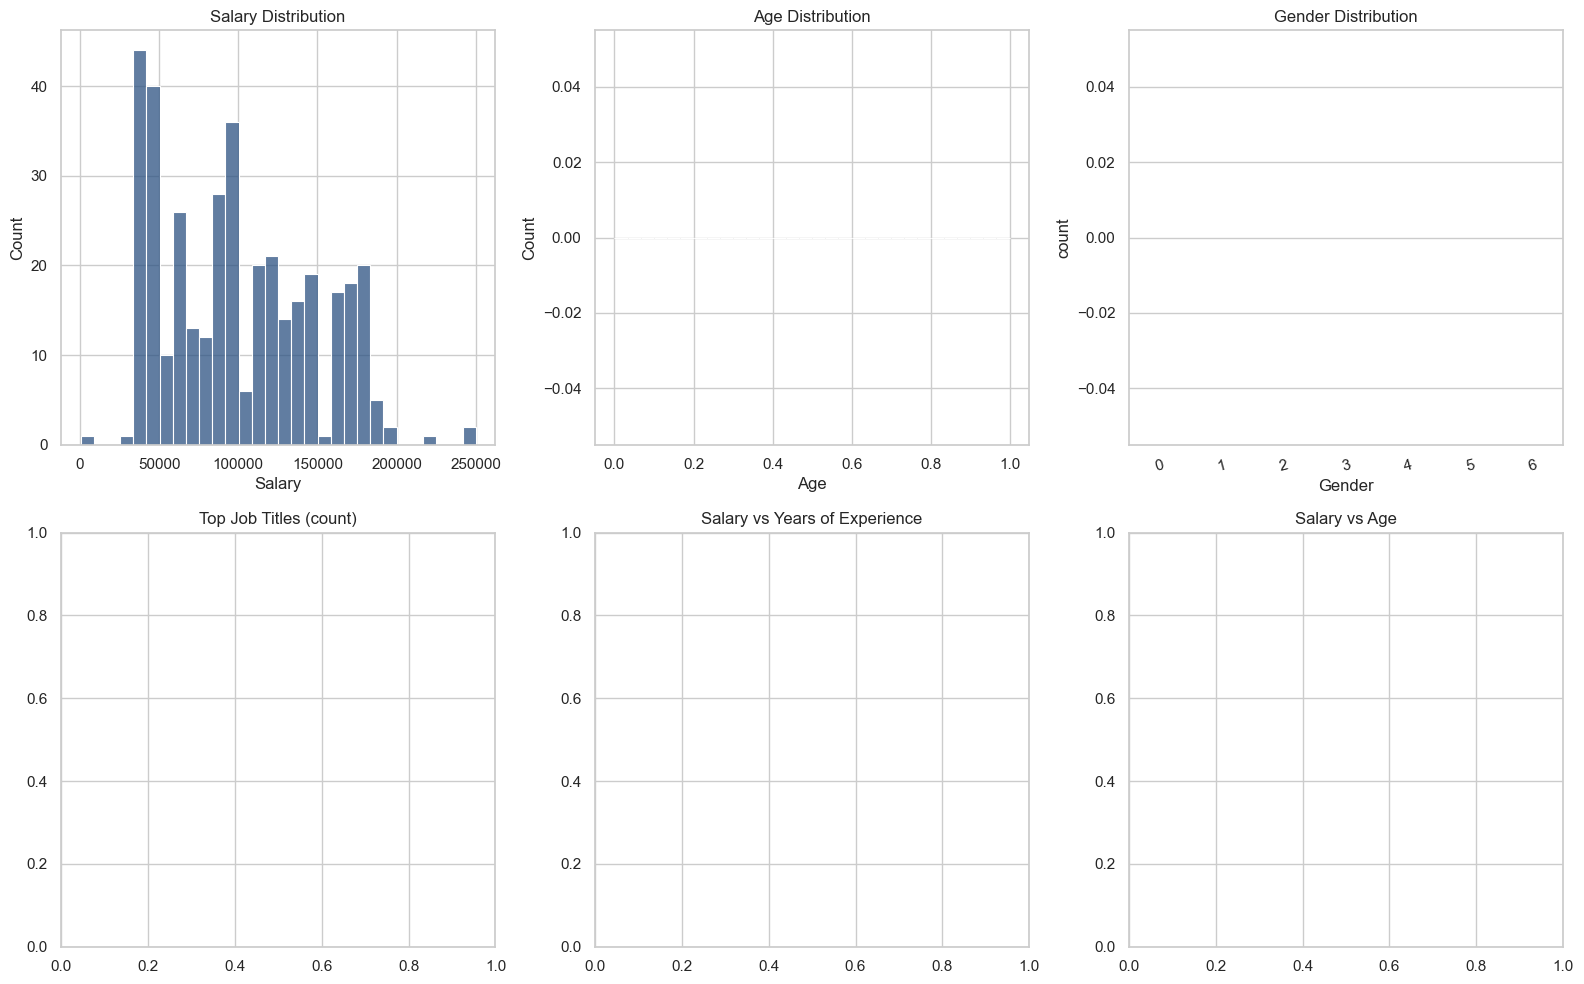

In [24]:
# MODULE 5 — EDA Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

sns.histplot(df["Salary"], bins=30, ax=axes[0,0], color="#2c5282")
axes[0,0].set_title("Salary Distribution")

sns.histplot(df["Age"], bins=30, ax=axes[0,1], color="#1f3b73")
axes[0,1].set_title("Age Distribution")

sns.countplot(x="Gender", data=df, ax=axes[0,2], palette="Blues")
axes[0,2].set_title("Gender Distribution")
axes[0,2].tick_params(axis='x', rotation=15)

top_jobs = df["Job Title"].value_counts().head(15)
sns.barplot(x=top_jobs.values, y=top_jobs.index, ax=axes[1,0], palette="Blues_r")
axes[1,0].set_title("Top Job Titles (count)")

sns.scatterplot(x="Years of Experience", y="Salary", data=df, ax=axes[1,1],
                color="#2c5282", alpha=0.7)
axes[1,1].set_title("Salary vs Years of Experience")

sns.scatterplot(x="Age", y="Salary", data=df, ax=axes[1,2],
                color="#1f3b73", alpha=0.7)
axes[1,2].set_title("Salary vs Age")

plt.tight_layout()
plt.show()



## MODULE 6 — Bias & Fairness Diagnostics (Dataset-Level Preview)

The full application includes a **Bias & Fairness Audit** inside the  
`InsightEngine` (`app/insights/engine.py`), where we:

- Compute salary gaps between subgroups (gender, education, age groups).
- Report gap ratios, absolute differences, and parity vs population mean.
- Raise deterministic bias flags per dimension.

In this notebook we provide a **compact preview** of those ideas at the **dataset level**:

- Salary distribution by gender.
- Salary distribution by education level.
- Salary distribution by age groups (binned).
- Basic summary statistics per group.

This is **descriptive only** and is meant to:

- Show how the salary landscape looks across groups.
- Provide context for the downstream bias module in the InsightEngine.


In [25]:
NUMERIC = ["Age", "Years of Experience"]
CATEGORICAL = ["Gender", "Education Level", "Job Title"]

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, NUMERIC),
        ("cat", categorical_pipeline, CATEGORICAL),
    ],
    remainder="drop",
)

preprocessor


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## MODULE 7 — Preprocessing Logic

The production pipeline uses a **strict 5-feature schema**:

- `Age` (numeric)
- `Gender` (categorical)
- `Education Level` (categorical)
- `Job Title` (categorical)
- `Years of Experience` (numeric)

Preprocessing design (mirroring `app/ml/train_pipeline.py`):

- **Numeric features** (`Age`, `Years of Experience`)
  - Imputation: median
  - No scaling required for tree-based models.
- **Categorical features** (`Gender`, `Education Level`, `Job Title`)
  - Imputation: most frequent
  - Encoding: `OneHotEncoder(handle_unknown="ignore", sparse_output=False)`
    - This allows the model to safely handle unseen categories at inference.
- All of this is wrapped in a `ColumnTransformer` so that:
  - Only these 5 columns are consumed.
  - The output matches the shape expected by the final model.
  - The same structure is used in **training and inference**.


In [26]:
# MODULE 7 — Build and Train Model (production-aligned)
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42,
    )),
])

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
len(y_pred)


ValueError: Found array with 0 feature(s) (shape=(298, 0)) while a minimum of 1 is required.

In [27]:
# MODULE 8 — Evaluate Model
def eval_metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    rmse = mean_squared_error(y_true, y_hat, squared=False)
    r2 = r2_score(y_true, y_hat)
    return mae, rmse, r2

rf_mae, rf_rmse, rf_r2 = eval_metrics(y_test, y_pred)

print("RandomForestRegressor (production)")
print(f"  MAE  : {rf_mae:.4f}")
print(f"  RMSE : {rf_rmse:.4f}")
print(f"  R^2  : {rf_r2:.4f}")


NameError: name 'y_pred' is not defined

In [28]:
# MODULE 9 — Export Artifacts (FastAPI-compatible)
preprocessor_path = ARTIFACT_DIR / "preprocessor.pkl"
model_path = ARTIFACT_DIR / "model.pkl"

joblib.dump(preprocessor, preprocessor_path)
joblib.dump(rf_model, model_path)

preprocessor_path, model_path


(WindowsPath('C:/Users/Usuario/Desktop/recruiting_insight_engine/notebooks/app/ml/artifacts/preprocessor.pkl'),
 WindowsPath('C:/Users/Usuario/Desktop/recruiting_insight_engine/notebooks/app/ml/artifacts/model.pkl'))

## MODULE 11 — Final Summary

**Modeling Decisions**

- **Features:**  
  `Age`, `Gender`, `Education Level`, `Job Title`, `Years of Experience`
- **Preprocessing:**
  - Numeric: median imputation
  - Categorical: most-frequent imputation + OneHotEncoder with `handle_unknown="ignore"`
  - All wrapped in a `ColumnTransformer` to preserve a strict, consistent schema.
- **Main Estimator:**  
  `RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42)`
- **Baseline Estimator (for reference):**  
  `LinearRegression`

**Performance (on held-out test split):**

- RandomForestRegressor:
  - MAE / RMSE / R² reported in the previous cell.
- LinearRegression:
  - Serves as a simple baseline to contextualize performance.

**Alignment with the Application**

- The exported artifacts:
  - `app/ml/artifacts/preprocessor.pkl`
  - `app/ml/artifacts/model.pkl`
- are consumed by:
  - `app/ml/inference.py` (for FastAPI predictions)
  - `app/insights/engine.py` (for market insights, cohort comparisons, bias audit, and interpretability).

**Bias & Fairness**

- This notebook only runs **descriptive salary diagnostics** by group (gender, education level, age groups).
- The full **Bias & Fairness Audit** logic (gap ratios, parity vs population, flags) is implemented deterministically in:
  - `app/insights/engine.py`
- This separation keeps:
  - Training code simple and reproducible.
  - Bias-related logic explicit, transparent, and testable in the **Insight Engine** layer.

This concludes the EDA + training documentation for the *Recruiting Insight Engine*.


In [ ]:
df.columns.tolist()


['Age',
 'Gender',
 'Education Level',
 'Job Title',
 'Years of Experience',
 'Salary',
 'Age Group']

In [30]:
import pandas as pd

desc = pd.read_csv("../data/raw/descriptions.csv")
people = pd.read_csv("../data/raw/people.csv")
salary = pd.read_csv("../data/raw/salary.csv")

desc.head(), people.head(), salary.head()


(   id                                        Description
 0   0  I am a 32-year-old male working as a Software ...
 1   1  I am a 28-year-old data analyst with a Master'...
 2   2  I am a 45-year-old Senior Manager with a PhD a...
 3   3  I am a 36-year-old female Sales Associate with...
 4   4  I am a 52-year-old male with over two decades ...,
    id   Age  Gender Education Level          Job Title  Years of Experience
 0   0  32.0    Male      Bachelor's  Software Engineer                  5.0
 1   1  28.0  Female        Master's       Data Analyst                  3.0
 2   2  45.0    Male             PhD     Senior Manager                 15.0
 3   3  36.0  Female      Bachelor's    Sales Associate                  7.0
 4   4  52.0    Male        Master's           Director                 20.0,
    id    Salary
 0   0   90000.0
 1   1   65000.0
 2   2  150000.0
 3   3   60000.0
 4   4  200000.0)